# Spatial Clustering and Network Structure of Global Airports

### Computational Tools for Data Science

#### Group 49

Mathilde Block - s204201

Emilie Leonora Wenner - s193602

Fie Christina Moeller - s205291

Kenneth Raahauge - s204420

Sofie Amalie Groth Dige - s211917


## Section 1: Clustering

In [1]:
# Libs
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, k_means, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import haversine_distances

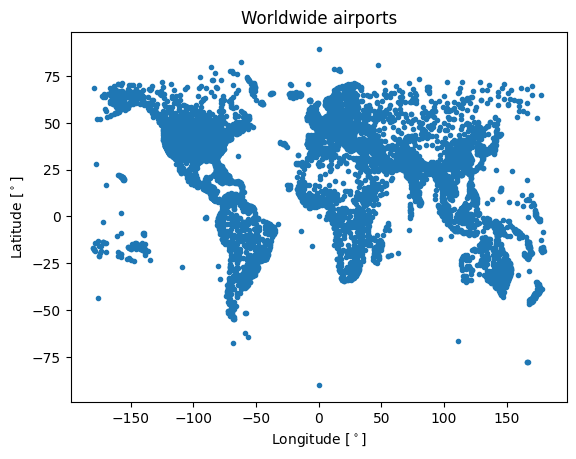

In [2]:
df_airports = pd.read_csv("data/airports.csv") # Read data
df_geo = df_airports[["ICAO", "Longitude", "Latitude"]] # ICAO is the simplest unique identifier

def airport_map(longitude,latitude,title="Worldwide airports",labels=None,cmap=None):

    """
    This function plots a set of coordinates a points. Can also takes labels for clustering
    """
    
    plt.scatter(longitude, latitude,marker=".",c=labels,cmap=cmap)
    plt.xlabel("Longitude [$^\circ$]")
    plt.ylabel("Latitude $[^\circ$]")
    plt.title(title)
    plt.show()

airport_map(df_geo["Longitude"],df_geo["Latitude"])

## DBSCAN
First we determine MinPts and epsilon for DBSCAN by using the same methodology as in this article [article](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd) from Medium. When making the K-distance plot, we use the haversine distance, which is appropiate for determining the distance between points on a sphere


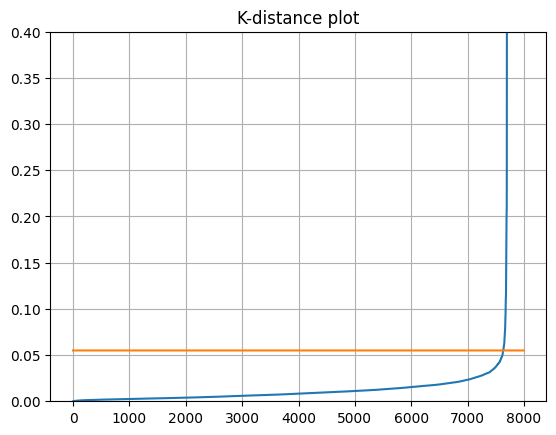

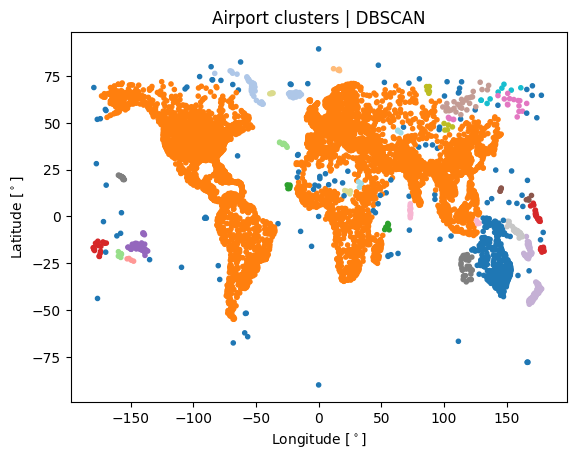

In [3]:
# Dataset
X = np.radians(df_geo[["Latitude", "Longitude"]])

# From (Ester et al. 1996) we know tat MinPts should be 2*dim = 4
MinPts = 4

# Next we determine create the K-distance graph
neighbors = NearestNeighbors(n_neighbors=MinPts,metric='haversine')

# Fit the nearest neighbors
neighbors_fit = neighbors.fit(X)

# Define
distances, indices = neighbors_fit.kneighbors(X)

# Plot
# Sort the distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Create vertical line to determine epsilone
x = np.arange(0,8000)
epsilon= 0.055 # Test different epsilons and determine from the plot
y = np.ones(8000)*epsilon


# Plotting
plt.plot(distances)
plt.plot(x,y)
plt.ylim(0,0.4)
plt.title("K-distance plot")
plt.grid()
plt.show()


# DBSCAN
# Haversine is the most appropiate way to determine distances between points on a sphere
dbscan = DBSCAN(eps=epsilon, min_samples=MinPts,metric='haversine')

# Define labels
labels_dbscan = dbscan.fit_predict(X)

# Visualization
airport_map(longitude=df_geo["Longitude"],title="Airport clusters | DBSCAN",latitude=df_geo["Latitude"],labels=labels_dbscan,cmap="tab20")

## K-means clustering

For determining the number of clusters in K-means clustering we use the [elbow method](https://www.geeksforgeeks.org/machine-learning/ml-determine-the-optimal-value-of-k-in-k-means-clustering/).

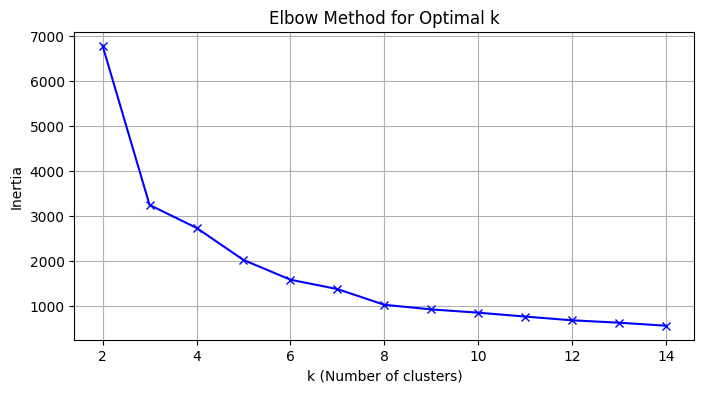

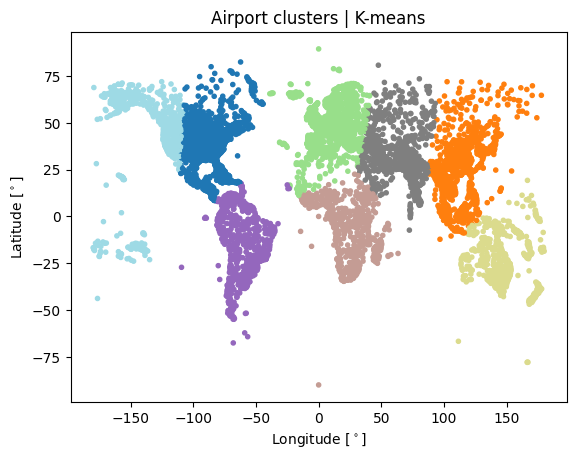

In [4]:

# List for containing intertias
inertias = []
K_range = range(2, 15)  # Test k from 2 to 14


# Loop over multiple number of clusters
for k in K_range:
    # Use random_state for reproducibility
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

# plotting
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

# From the elbow mehtod we determine that 8 clusters is an appropiate number
# K-means
_, labels_kmeans, _ = k_means(X, n_clusters=8, n_init="auto", random_state=0)

# Visualization
airport_map(longitude=df_geo["Longitude"],title="Airport clusters | K-means",latitude=df_geo["Latitude"],labels=labels_kmeans,cmap="tab20")


## Agglomerative clustering
We determine the number of clusters for agglomerative clustering using a [hierarchical clustering dendogram](https://www.geeksforgeeks.org/machine-learning/hierarchical-clustering/).

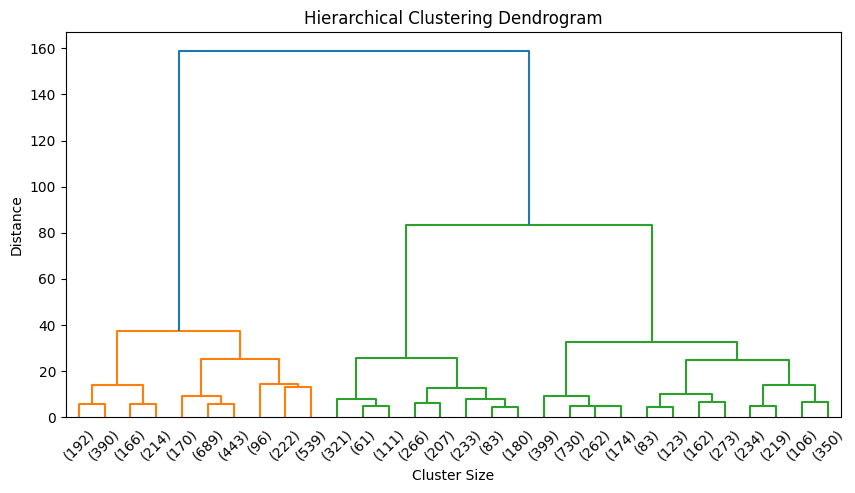

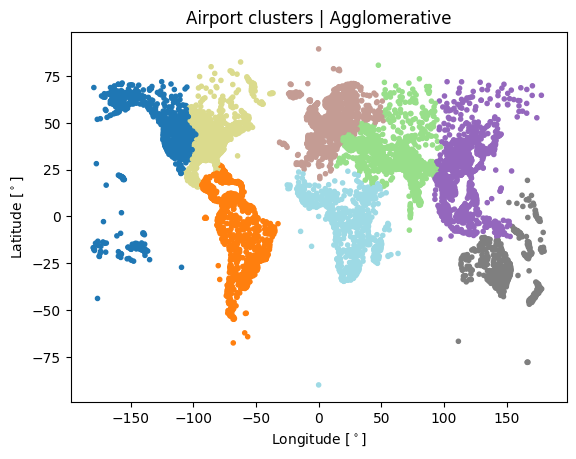

In [5]:
# 'ward' minimizes the variance of the clusters being merged
Z = linkage(X, method='ward')

# Plotting
plt.figure(figsize=(10, 5))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(Z, truncate_mode='lastp', p=30) # p=30 shows only the top 30 merges for readability
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()


# From the dendogram we read of the number of clusters to be 8
# Agglomerative
hc = AgglomerativeClustering(n_clusters=8)
labels_agglomerative = hc.fit_predict(X)

airport_map(longitude=df_geo["Longitude"],title="Airport clusters | Agglomerative",latitude=df_geo["Latitude"],labels=labels_agglomerative,cmap="tab20")

## Davies-Bouldin Index

In [6]:
# Assign labels to airports
df_geo['c_dbscan'] = labels_dbscan.copy()
df_geo['c_kmeans'] = labels_kmeans.copy()
df_geo['c_agglomerative'] = labels_agglomerative.copy()

def DB_index(df,c_header):
    """
    This function takes a list of airport coordinates with cluster labels and computes the Davies-Bouldin index.
    """

    # List clusters
    cluster_list = df[df[c_header] != -1][c_header].unique()
    r_list = [] # List to for containing radii
    center_list = [] # List for containing centers of clusters
    for cluster in cluster_list:
        # Select airports from given cluster
        airports = df[df[c_header] == cluster]
        
        # Convert points to radians
        points_rad = np.radians(airports[["Latitude", "Longitude"]])
        # Determine center
        center = np.mean(points_rad, axis=0).values.reshape(1, -1)

        # Distances between center and all points
        dists = haversine_distances(points_rad, center)

        # Number of points
        C = airports.shape[0]

        # Radius
        r = np.sum(dists) / C

        # Append information
        r_list.append(r)
        center_list.append(center)
    

    # Amount of clusters
    k = cluster_list.shape[0]

    # Compute Davies Bouldin index
    DB = (1/k) * sum(max((r_list[i] + r_list[j]) / haversine_distances(center_list[i], center_list[j])[0][0] for j in range(k) if i != j) for i in range(k))

    return DB

/var/folders/t2/8rjm39y94g5fsj89vww4fv180000gp/T/ipykernel_64782/4057268527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['c_dbscan'] = labels_dbscan.copy()
/var/folders/t2/8rjm39y94g5fsj89vww4fv180000gp/T/ipykernel_64782/4057268527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['c_kmeans'] = labels_kmeans.copy()
/var/folders/t2/8rjm39y94g5fsj89vww4fv180000gp/T/ipykernel_64782/4057268527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [7]:
print(f"The Davies-Bouldin index of the clustering using DBSCAN is: {np.round(DB_index(df_geo,'c_dbscan'),3)}")
print(f"The Davies-Bouldin index of the clustering using K-means is: {np.round(DB_index(df_geo,'c_kmeans'),3)}")
print(f"The Davies-Bouldin index of the clustering using agglomerative is: {np.round(DB_index(df_geo,'c_agglomerative'),3)}")


The Davies-Bouldin index of the clustering using DBSCAN is: 1.52
The Davies-Bouldin index of the clustering using K-means is: 0.768
The Davies-Bouldin index of the clustering using agglomerative is: 0.797


## Section 2: Network Analysis

In [8]:
# Import required libraries
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import numpy as np
import re

In [9]:
# Load data
routes = pd.read_csv('data/routes.csv')
airports = pd.read_csv('data/airports.csv')

print(f"Routes: {len(routes)} rows")
print(f"Airports: {len(airports)} rows")

Routes: 67663 rows
Airports: 7698 rows


In [10]:
# Clean data
routes['Source airport ID'] = pd.to_numeric(routes['Source airport ID'], errors='coerce')
routes['Destination airport ID'] = pd.to_numeric(routes['Destination airport ID'], errors='coerce')
routes = routes.dropna(subset=['Source airport ID', 'Destination airport ID'])
routes['Source airport ID'] = routes['Source airport ID'].astype(int)
routes['Destination airport ID'] = routes['Destination airport ID'].astype(int)

print(f"Cleaned routes: {len(routes)} rows")

Cleaned routes: 67240 rows


In [11]:
# Create network graph
G = nx.from_pandas_edgelist(
    routes,
    source='Source airport ID',
    target='Destination airport ID',
    create_using=nx.DiGraph()
)

print(f"Network created:")
print(f"- Nodes (airports): {G.number_of_nodes()}")
print(f"- Edges (routes): {G.number_of_edges()}")

Network created:
- Nodes (airports): 3330
- Edges (routes): 37274


In [12]:
# Compute Louvain communities
np.random.seed(11)
partition = community_louvain.best_partition(G.to_undirected())

print(f"Community detection completed:")
print(f"- Total communities found: {len(set(partition.values()))}")
print(f"- Airports with community assignments: {len(partition)}")

Community detection completed:
- Total communities found: 31
- Airports with community assignments: 3330


In [13]:
def analyze_communities(graph, airports_df, partition, top_n=500):
    """
    Analyze communities in detail with PageRank, betweenness centrality, and statistics
    """
    # Get top N most connected airports
    top_nodes = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:top_n]
    subG = graph.subgraph([n for n, _ in top_nodes])
    
    # Compute centrality measures for the subgraph
    pagerank = nx.pagerank(subG)
    betweenness = nx.betweenness_centrality(subG)
    
    # Group nodes by community
    communities = {}
    for node in subG.nodes():
        comm_id = partition.get(node, 0)
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)
    
    # Analyze each community
    community_stats = []
    detailed_analysis = {}
    
    for comm_id, nodes in communities.items():
        comm_subgraph = subG.subgraph(nodes)
        
        # Basic statistics
        num_airports = len(nodes)
        num_routes = comm_subgraph.number_of_edges()
        avg_degree = sum(dict(comm_subgraph.degree()).values()) / num_airports if num_airports > 0 else 0
        
        # Top 5 PageRank airports in this community
        comm_pagerank = {node: pagerank[node] for node in nodes}
        top_pagerank = sorted(comm_pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
        
        # Top 5 Betweenness centrality airports (transfer hubs)
        comm_betweenness = {node: betweenness[node] for node in nodes}
        top_betweenness = sorted(comm_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
        
        # Get airport names for top hub (PageRank)
        top_hub_id = top_pagerank[0][0] if top_pagerank else None
        top_hub_name = "Unknown"
        top_hub_country = "Unknown"
        
        if top_hub_id:
            try:
                airport_data = airports_df[airports_df['Airport ID'] == int(top_hub_id)]
                if not airport_data.empty:
                    top_hub_name = airport_data['City'].iloc[0]
                    top_hub_country = airport_data['Country'].iloc[0]
            except (ValueError, TypeError):
                pass
        
        # Get airport names for top transfer hub (Betweenness)
        top_transfer_id = top_betweenness[0][0] if top_betweenness else None
        top_transfer_name = "Unknown"
        top_transfer_country = "Unknown"
        
        if top_transfer_id:
            try:
                airport_data = airports_df[airports_df['Airport ID'] == int(top_transfer_id)]
                if not airport_data.empty:
                    top_transfer_name = airport_data['City'].iloc[0]
                    top_transfer_country = airport_data['Country'].iloc[0]
            except (ValueError, TypeError):
                pass
        
        # Count countries in this community
        countries = set()
        for node_id in nodes:
            try:
                airport_data = airports_df[airports_df['Airport ID'] == int(node_id)]
                if not airport_data.empty:
                    countries.add(airport_data['Country'].iloc[0])
            except (ValueError, TypeError):
                pass
        
        # Store detailed analysis
        detailed_analysis[comm_id] = {
            'nodes': nodes,
            'top_pagerank': top_pagerank,
            'top_betweenness': top_betweenness,
            'num_airports': num_airports,
            'num_routes': num_routes,
            'avg_degree': avg_degree,
            'top_hub_name': top_hub_name,
            'top_hub_country': top_hub_country,
            'top_transfer_name': top_transfer_name,
            'top_transfer_country': top_transfer_country,
            'countries_count': len(countries)
        }
        
        # Store stats for table
        community_stats.append({
            'Community': comm_id,
            '# Airports': num_airports,
            '# Routes': num_routes,
            'Avg. Degree': f"{avg_degree:.1f}",
            '# Countries': len(countries),
            'Top Hub (PageRank)': f"{top_hub_name}, {top_hub_country}",
            'Top Transfer Hub (Betweenness)': f"{top_transfer_name}, {top_transfer_country}"
        })
    
    # Sort by number of airports (largest first)
    community_stats.sort(key=lambda x: x['# Airports'], reverse=True)
    
    # Create and display summary table
    stats_df = pd.DataFrame(community_stats)
    
    print("=== COMMUNITY ANALYSIS SUMMARY ===")
    print(stats_df.to_string(index=False))
    print(f"\nTotal Communities Analyzed: {len(community_stats)}")
    print(f"Total Airports in Analysis: {sum(stat['# Airports'] for stat in community_stats)}")
    print(f"Total Routes in Analysis: {sum(stat['# Routes'] for stat in community_stats)}")
    
    return detailed_analysis, stats_df

In [14]:
# Run community analysis
detailed_communities, community_summary = analyze_communities(G, airports, partition, top_n=400)

=== COMMUNITY ANALYSIS SUMMARY ===
 Community  # Airports  # Routes Avg. Degree  # Countries      Top Hub (PageRank) Top Transfer Hub (Betweenness)
         4         151      6906        91.5           38      Frankfurt, Germany             Frankfurt, Germany
         3          88      3020        68.6           16 New York, United States        New York, United States
         6          75      2420        64.5           14          Beijing, China                 Beijing, China
         2          44       757        34.4           27        Istanbul, Turkey    Dubai, United Arab Emirates
         0          19       214        22.5           10          Moscow, Russia                 Moscow, Russia
         1          14       108        15.4            5       Sao Paulo, Brazil         Rio De Janeiro, Brazil
         9           9        46        10.2            5       Sydney, Australia              Sydney, Australia

Total Communities Analyzed: 7
Total Airports in Analysis: 40

## Geographic Visualization

In [15]:
def create_community_geographic_network(graph, airports_df, partition, top_n=150, title="Geographic Airport Communities"):
    """
    Create a geographic network visualization that emphasizes Louvain communities
    """
    # Get top N most connected airports
    top_nodes = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:top_n]
    subG = graph.subgraph([n for n, _ in top_nodes])
    
    # Create position dictionary using actual coordinates
    pos = {}
    valid_nodes = []
    community_data = {}
    
    for node in subG.nodes():
        try:
            nid = int(node)
        except (ValueError, TypeError):
            continue
            
        airport_data = airports_df[airports_df['Airport ID'] == nid]
        if not airport_data.empty:
            lat = airport_data['Latitude'].iloc[0]
            lon = airport_data['Longitude'].iloc[0]
            
            # Skip invalid coordinates
            if not (lat == 0 and lon == 0):
                pos[node] = (lon, lat)
                valid_nodes.append(node)
                
                # Store community and geographic info
                community_id = partition.get(node, 0)
                if community_id not in community_data:
                    community_data[community_id] = {
                        'nodes': [],
                        'airports': [],
                        'countries': set()
                    }
                community_data[community_id]['nodes'].append(node)
                community_data[community_id]['airports'].append(airport_data['City'].iloc[0])
                community_data[community_id]['countries'].add(airport_data['Country'].iloc[0])
    
    # Only keep nodes with valid coordinates
    subG = subG.subgraph(valid_nodes)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(20, 12))
    
    # Set ocean blue background
    ax.set_facecolor("#E6F3FF")  # Light blue ocean color
    
    # Draw world boundaries
    world_lons = [-180, 180, 180, -180, -180]
    world_lats = [-90, -90, 90, 90, -90]
    ax.plot(world_lons, world_lats, 'k-', linewidth=0.5, alpha=0.3)
    
    # Add reference lines
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
    
    # Get unique communities and assign distinct colors
    unique_communities = list(set(partition.get(n, 0) for n in subG.nodes()))
    # Use a more vibrant colormap without grey tones
    community_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_communities)))
    color_map = dict(zip(unique_communities, community_colors))
    
    # Draw edges FIRST (behind nodes) - grouped by communities
    for edge in subG.edges():
        if edge[0] in pos and edge[1] in pos:
            x1, y1 = pos[edge[0]]
            x2, y2 = pos[edge[1]]
            
            comm1 = partition.get(edge[0], 0)
            comm2 = partition.get(edge[1], 0)
            
            if comm1 == comm2:  # Same community
                ax.plot([x1, x2], [y1, y2], color=color_map[comm1], 
                        alpha=0.5, linewidth=0.6)
            else:  # Different communities
                ax.plot([x1, x2], [y1, y2], 'darkgrey', 
                        alpha=0.3, linewidth=0.2)
    
    # Draw nodes SECOND (on top of edges) - colored by community
    for node in subG.nodes():
        if node in pos:
            x, y = pos[node]
            community = partition.get(node, 0)
            size = 50 + 10 * subG.degree(node)
            
            ax.scatter(x, y, c=[color_map[community]], s=size, 
                       alpha=0.9, edgecolors='black', linewidth=0.8, zorder=2)
    
    # Add labels for top airports in each major community
    for comm_id, comm_info in community_data.items():
        if len(comm_info['nodes']) >= 3:  # Only label major communities
            # Find the most connected airport in this community
            comm_nodes = comm_info['nodes']
            top_node = max(comm_nodes, key=lambda n: subG.degree(n))
            
            if top_node in pos:
                try:
                    nid = int(top_node)
                    airport_data = airports_df[airports_df['Airport ID'] == nid]
                    if not airport_data.empty:
                        city = airport_data['City'].iloc[0]
                        country = airport_data['Country'].iloc[0]
                        x, y = pos[top_node]
                        ax.annotate(f"{city}\n(Community {comm_id})", 
                                   (x, y), xytext=(5, 5), 
                                   textcoords='offset points', fontsize=8,
                                   bbox=dict(boxstyle='round,pad=0.3', 
                                           facecolor=color_map[comm_id], 
                                           alpha=0.9, edgecolor='black'),
                                   ha='left', fontweight='bold')
                except (ValueError, TypeError):
                    continue
    
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return subG, pos, community_data

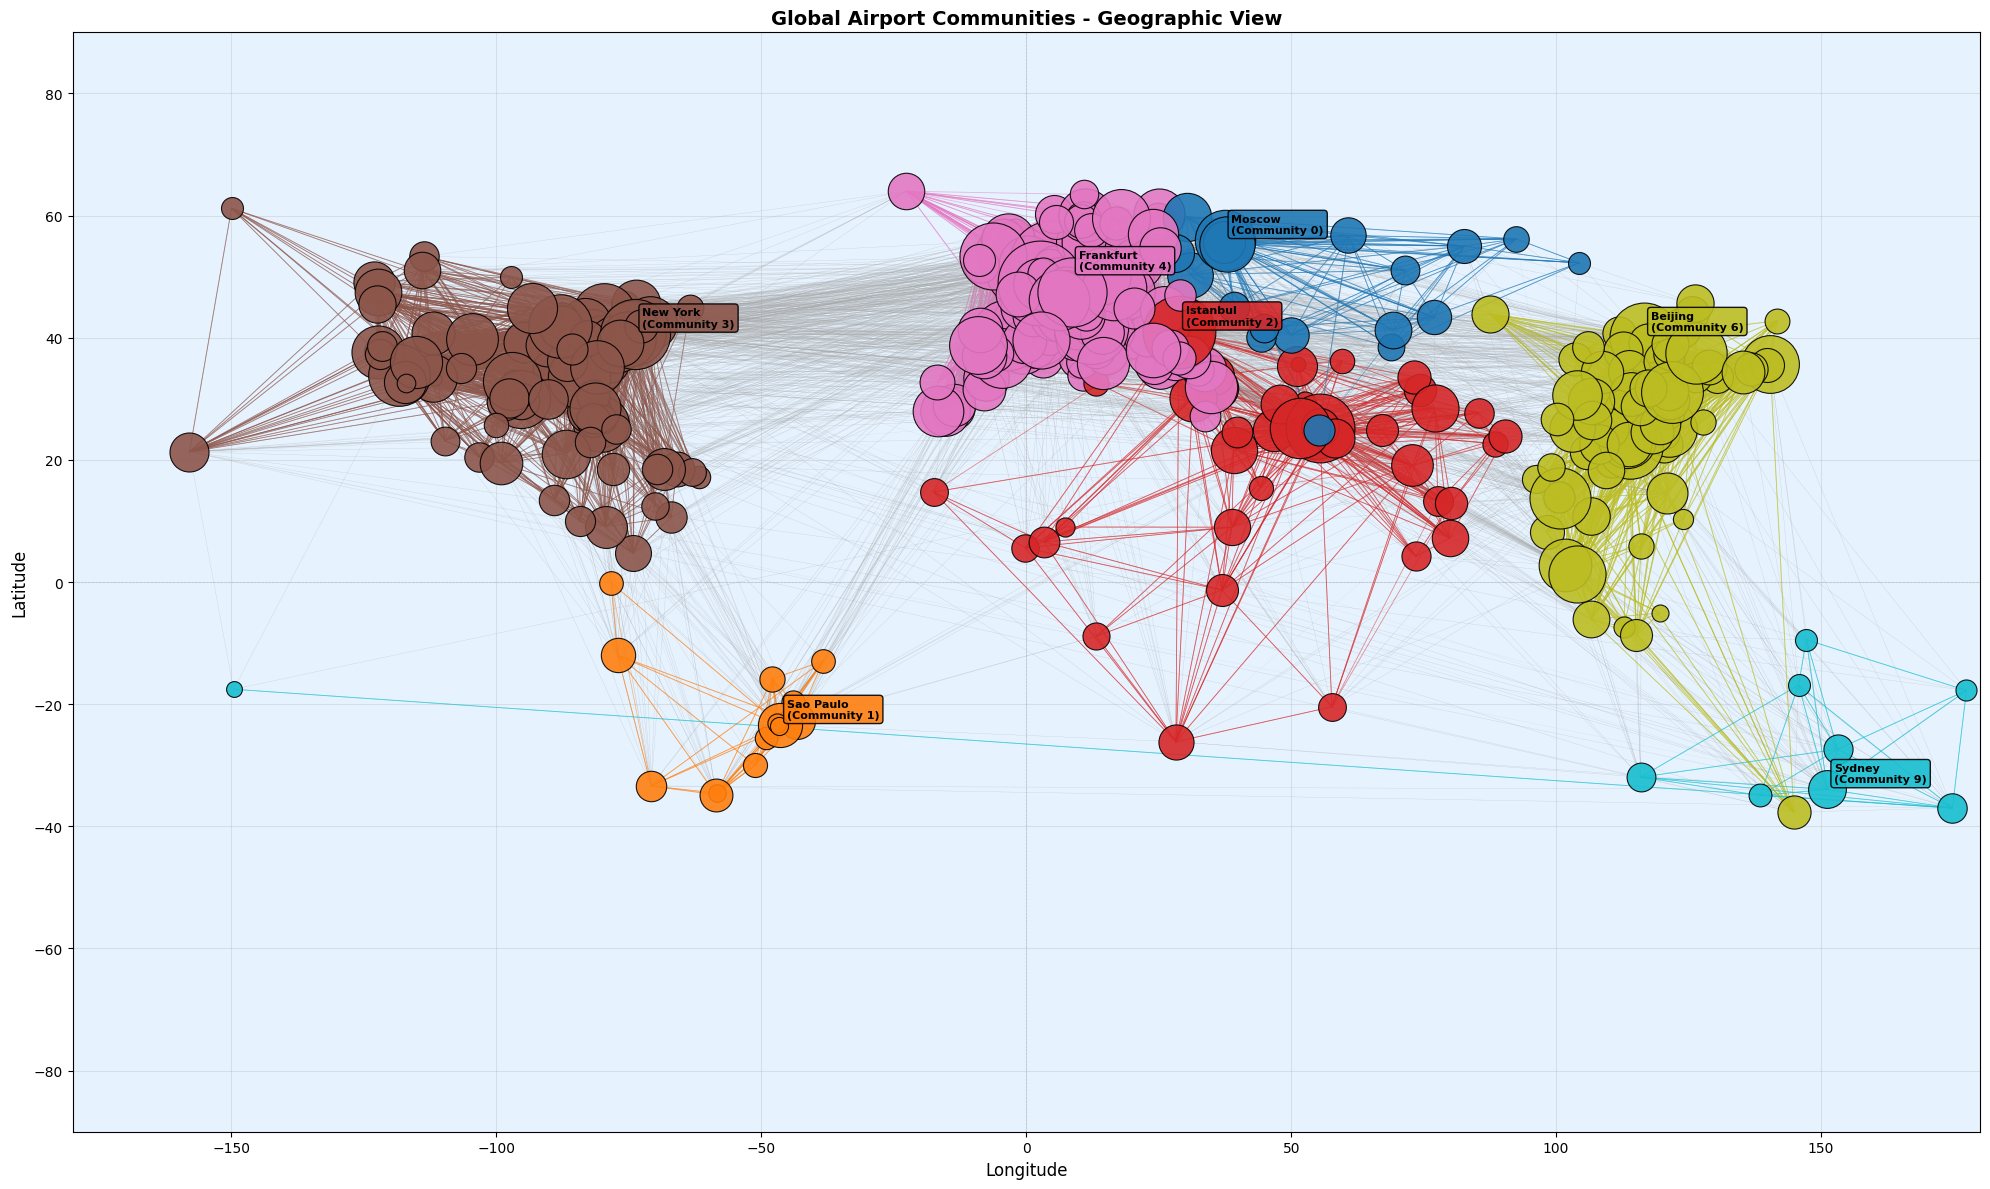

In [16]:
# Create geographic visualization of communities
comm_subG, comm_pos, comm_data = create_community_geographic_network(
    G, airports, partition, top_n=400,
    title="Global Airport Communities - Geographic View"
)

In [17]:
# Display detailed analysis for top communities
print("\n=== DETAILED COMMUNITY BREAKDOWN ===")

for i, (comm_id, analysis) in enumerate(list(detailed_communities.items())[:7]):
    print(f"\n--- COMMUNITY {comm_id} ({analysis['num_airports']} airports, {analysis['num_routes']} routes) ---")
    
    print(f"\nTop 5 PageRank Airports:")
    for j, (node_id, pr_score) in enumerate(analysis['top_pagerank'], 1):
        try:
            airport_data = airports[airports['Airport ID'] == int(node_id)]
            if not airport_data.empty:
                name = airport_data['City'].iloc[0]
                country = airport_data['Country'].iloc[0]
                code = airport_data['IATA'].iloc[0] if 'IATA' in airport_data.columns else 'N/A'
                print(f"  {j}. {name}, {country} ({code}) - PageRank: {pr_score:.4f}")
        except (ValueError, TypeError, IndexError):
            print(f"  {j}. Airport ID {node_id} - PageRank: {pr_score:.4f}")
    
    print(f"\nTop 5 Betweenness Centrality Airports (Transfer Hubs):")
    for j, (node_id, bc_score) in enumerate(analysis['top_betweenness'], 1):
        try:
            airport_data = airports[airports['Airport ID'] == int(node_id)]
            if not airport_data.empty:
                name = airport_data['City'].iloc[0]
                country = airport_data['Country'].iloc[0]
                code = airport_data['IATA'].iloc[0] if 'IATA' in airport_data.columns else 'N/A'
                print(f"  {j}. {name}, {country} ({code}) - Betweenness: {bc_score:.4f}")
        except (ValueError, TypeError, IndexError):
            print(f"  {j}. Airport ID {node_id} - Betweenness: {bc_score:.4f}")
    
    print(f"\nCommunity Statistics:")
    print(f"  • Average degree: {analysis['avg_degree']:.2f}")
    print(f"  • Network density: {(analysis['num_routes'] * 2) / (analysis['num_airports'] * (analysis['num_airports'] - 1)):.4f}")
    print("-" * 80)


=== DETAILED COMMUNITY BREAKDOWN ===

--- COMMUNITY 9 (9 airports, 46 routes) ---

Top 5 PageRank Airports:
  1. Sydney, Australia (SYD) - PageRank: 0.0023
  2. Auckland, New Zealand (AKL) - PageRank: 0.0017
  3. Brisbane, Australia (BNE) - PageRank: 0.0016
  4. Perth, Australia (PER) - PageRank: 0.0015
  5. Adelaide, Australia (ADL) - PageRank: 0.0011

Top 5 Betweenness Centrality Airports (Transfer Hubs):
  1. Sydney, Australia (SYD) - Betweenness: 0.0016
  2. Auckland, New Zealand (AKL) - Betweenness: 0.0007
  3. Brisbane, Australia (BNE) - Betweenness: 0.0004
  4. Perth, Australia (PER) - Betweenness: 0.0002
  5. Adelaide, Australia (ADL) - Betweenness: 0.0000

Community Statistics:
  • Average degree: 10.22
  • Network density: 1.2778
--------------------------------------------------------------------------------

--- COMMUNITY 2 (44 airports, 757 routes) ---

Top 5 PageRank Airports:
  1. Istanbul, Turkey (ISL) - PageRank: 0.0070
  2. Dubai, United Arab Emirates (DXB) - PageRan

In [18]:
# Enhanced community summary with geographic distribution
print("\n=== IMPROVED COMMUNITY SUMMARY TABLE ===")

enhanced_stats = []
for comm_id, analysis in detailed_communities.items():
    # Get geographic distribution
    countries = set()
    for node_id in analysis['nodes']:
        try:
            airport_data = airports[airports['Airport ID'] == int(node_id)]
            if not airport_data.empty:
                countries.add(airport_data['Country'].iloc[0])
        except (ValueError, TypeError):
            pass
    
    enhanced_stats.append({
        'Community': f"C{comm_id}",
        'Airports': analysis['num_airports'],
        'Routes': analysis['num_routes'],
        'Avg Degree': f"{analysis['avg_degree']:.1f}",
        'Countries': len(countries),
        'Top Hub': f"{analysis['top_hub_name']}",
        'Hub Country': f"{analysis['top_hub_country']}"
    })

# Sort by number of airports
enhanced_stats.sort(key=lambda x: x['Airports'], reverse=True)

# Display as formatted table
enhanced_df = pd.DataFrame(enhanced_stats)
print(enhanced_df.to_string(index=False))

# Summary statistics
print(f"\n=== GLOBAL NETWORK INSIGHTS ===")
total_airports = sum(stat['Airports'] for stat in enhanced_stats)
total_routes = sum(stat['Routes'] for stat in enhanced_stats)
total_countries = sum(stat['Countries'] for stat in enhanced_stats)

print(f"• Total airports analyzed: {total_airports}")
print(f"• Total routes analyzed: {total_routes}")
print(f"• Total communities: {len(enhanced_stats)}")
print(f"• Average airports per community: {total_airports/len(enhanced_stats):.1f}")
print(f"• Average routes per community: {total_routes/len(enhanced_stats):.1f}")
print(f"• Geographic coverage: {total_countries} country-community pairs")


=== IMPROVED COMMUNITY SUMMARY TABLE ===
Community  Airports  Routes Avg Degree  Countries   Top Hub   Hub Country
       C4       151    6906       91.5         38 Frankfurt       Germany
       C3        88    3020       68.6         16  New York United States
       C6        75    2420       64.5         14   Beijing         China
       C2        44     757       34.4         27  Istanbul        Turkey
       C0        19     214       22.5         10    Moscow        Russia
       C1        14     108       15.4          5 Sao Paulo        Brazil
       C9         9      46       10.2          5    Sydney     Australia

=== GLOBAL NETWORK INSIGHTS ===
• Total airports analyzed: 400
• Total routes analyzed: 13471
• Total communities: 7
• Average airports per community: 57.1
• Average routes per community: 1924.4
• Geographic coverage: 115 country-community pairs


In [19]:
def compute_metrics_for_topn(G, global_partition, topn_list=[100,150,250,500,1000]):
    results = []
    # global total degree (for coverage)
    total_degree = sum(dict(G.degree()).values())

    for top_n in topn_list:
        # choose top_n by degree
        top_nodes = [n for n,_ in sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n]]
        subG = G.subgraph(top_nodes).copy()

        # Use the global partition but filter to only nodes in subgraph
        partition = {node: global_partition.get(node, 0) for node in subG.nodes()}
        
        # Convert to undirected for modularity calculation
        subG_undirected = subG.to_undirected()
        # modularity on the undirected subgraph using global partition
        modularity = community_louvain.modularity(partition, subG_undirected)

        # number of communities (skip tiny ones if you want)
        num_comms = len(set(partition.values()))

        # sizes
        comm_sizes = pd.Series(list(partition.values())).value_counts().sort_values(ascending=False).values
        largest_comm = comm_sizes[0] if len(comm_sizes)>0 else 0
        smallest_comm = comm_sizes[-1] if len(comm_sizes)>0 else 0
        
        # count communities smaller than 3 airports
        small_communities = sum(1 for size in comm_sizes if size < 3)

        # compute cumulative degree coverage (sum of degrees in subgraph / total_degree)
        sub_degree_sum = sum(dict(subG.degree()).values())
        degree_coverage = sub_degree_sum / total_degree

        # optionally compute avg clustering coefficient (global)
        try:
            avg_clust = nx.average_clustering(subG)
        except Exception:
            avg_clust = np.nan

        results.append({
            'top_n': top_n,
            'nodes': subG.number_of_nodes(),
            'edges': subG.number_of_edges(),
            'modularity': modularity,
            'num_communities': num_comms,
            'largest_community_size': largest_comm,
            'smallest_community_size': smallest_comm,
            'small_communities_count': small_communities,
            'degree_coverage': degree_coverage,
            'avg_clustering': avg_clust
        })

    df = pd.DataFrame(results).set_index('top_n')
    return df

# Compute metrics for different network sizes
topn_list = [100, 200, 300, 350, 400, 450, 500]
metrics_df = compute_metrics_for_topn(G, partition, topn_list)
print(metrics_df)

# And show degree coverage
print("\nDegree coverage (fraction of total network degree):")
print(metrics_df['degree_coverage'].apply(lambda x: f"{x:.2%}"))

       nodes  edges  modularity  num_communities  largest_community_size  \
top_n                                                                      
100      100   3940    0.236569                7                      44   
200      200   8977    0.354376                7                      88   
300      300  13591    0.446883                7                     114   
350      350  15565    0.460798                7                     134   
400      400  17253    0.474173                7                     151   
450      450  18648    0.487959                9                     164   
500      500  20034    0.504255               10                     175   

       smallest_community_size  small_communities_count  degree_coverage  \
top_n                                                                      
100                          1                        2         0.105704   
200                          3                        0         0.240838   
300        

## Section 3: Textual Analysis

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import os

### Sentiment analysis

Based on this paper: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752. This paper uses a predefined txt file of different words and their associated ``happiness_rank``, as shown below.  

In [21]:
df = pd.read_csv('data/Data_Set_S1.txt', sep='	', skiprows=3)
df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [22]:
# convetr to dict for sentiment function
df_selected = df[['word', 'happiness_average']]
sentiment_dict = pd.Series(df_selected.happiness_average.values,index=df_selected.word).to_dict()

#list comprehension
def calculate_sentiment_lc(tokenized_text, sentiment_dict = sentiment_dict):
    """
    Input: tokenized_text - list of words (pre-processed)
           sentiment_dict - dictionary with words as keys and sentiment scores as values
    Output: average sentiment score of the input text
    """
    words = tokenized_text # assuming text is already pre-proccesed

    # create a list of scores for words present in sentiment_dict
    scores = [sentiment_dict[word] for word in words if word in sentiment_dict]
    
    if not scores:
        return 0.0
    
    return sum(scores) / len(scores)


We calculate the sentiment of each band page by:
- Extracting the readable_text (not raw text)
- Tokenizing the page with NLTK tokenzier
- Input the page into a calculate_sentiment function, which takes the score of sentiment words found in the dictionary provided by [source]. High scores means high sentiment (positive), lower scores means negative sentiment.
- The sentiment score is added as a node property. 


We can try this for a dataset of txt files from Wikipedia, but Wikipedia tends to be quite neutral and is not very interesting to do sentiment analysis on. We try it anyway, just to be sure

In [23]:
# path to txt files
data = "data/city_wikis/"
tokenizer = RegexpTokenizer(r'\w+')

results = []

for file in os.listdir(data):
    if file.endswith(".txt"):
        
        # read file text
        filepath = os.path.join(data, file)
        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read()
        
        # tokenize
        text_tokens = tokenizer.tokenize(text.lower())
        
        # your custom sentiment function
        sentiment_score = calculate_sentiment_lc(text_tokens)
        
        # save entry
        results.append({
            "city": file.replace(".txt",""),
            "sentiment_score": sentiment_score
        })

# convert to df
df = pd.DataFrame(results)
print(df)
df.to_csv("results/sentiment_scores_custom.csv", index=False)


        city  sentiment_score
0     moscow         5.501252
1   new_york         5.587870
2    bangkok         5.505279
3    beijing         5.519040
4  sao_paolo         5.504430
5   istanbul         5.504516
6     sydney         5.587492
7  frankfurt         5.495268


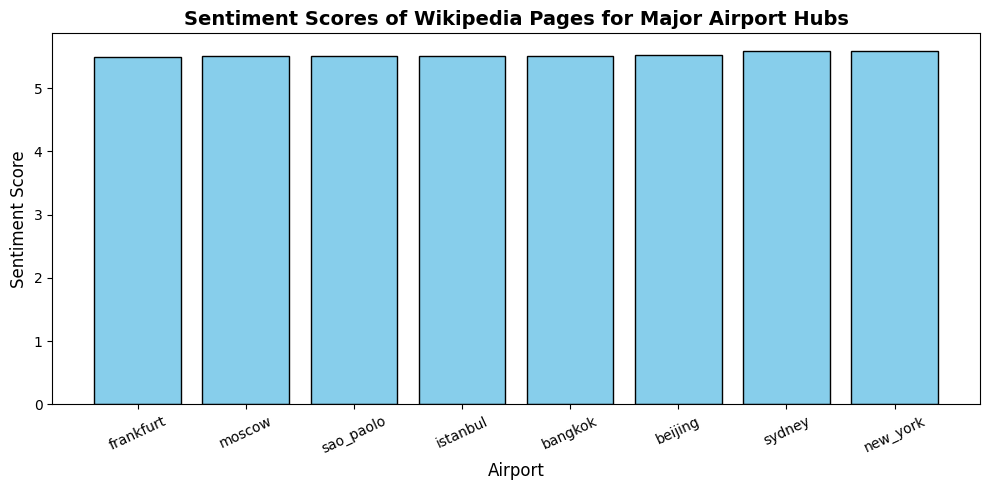

In [24]:
# sort bars go from lowest to highest (looks nicer)
df_sorted = df.sort_values("sentiment_score")

plt.figure(figsize=(10, 5))
plt.bar(df_sorted["city"], df_sorted["sentiment_score"], color="skyblue", edgecolor="black")

plt.ylabel("Sentiment Score", fontsize=12)
plt.xlabel("Airport", fontsize=12)
plt.title("Sentiment Scores of Wikipedia Pages for Major Airport Hubs", fontsize=14, fontweight="bold")

plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


As expected this is pretty boring. Maybe we can spice it up with [a different dataset](https://www.kaggle.com/datasets/furkanima/worldwide-travel-cities-ratings-and-climate?resource=download):

In [25]:
df = pd.read_csv('data/cities.csv')
df.head()

,id,city,country,region,short_description,latitude,longitude,avg_temp_monthly,ideal_durations,budget_level,culture,adventure,nature,beaches,nightlife,cuisine,wellness,urban,seclusion
0,c54acf38-3029-496b-8c7a-8343ad82785c,Milan,Italy,europe,"Chic streets lined with fashion boutiques, his...",45.464194,9.189635,"{""1"":{""avg"":3.7,""max"":7.8,""min"":0.4},""2"":{""avg...","[""Short trip"",""One week""]",Luxury,5,2,2,1,4,5,3,5,2
1,0bd12654-ed64-424e-a044-7bc574bcf078,Yasawa Islands,Fiji,oceania,"Crystal-clear waters, secluded beaches, and vi...",-17.290947,177.125786,"{""1"":{""avg"":28,""max"":30.8,""min"":25.8},""2"":{""av...","[""Long trip"",""One week""]",Luxury,2,4,5,5,2,3,4,1,5
2,73036cda-9134-46fc-a2c6-807782d59dfb,Whistler,Canada,north_america,Snow-capped peaks and lush forests create a se...,50.117190,-122.954302,"{""1"":{""avg"":-2.5,""max"":0.4,""min"":-5.5},""2"":{""a...","[""Short trip"",""Weekend"",""One week""]",Luxury,3,5,5,2,3,3,4,2,4
3,3872c9c0-6b6e-49e1-9743-f46bfe591b86,Guanajuato,Mexico,north_america,Winding cobblestone streets and colorful facad...,20.987700,-101.000000,"{""1"":{""avg"":15.5,""max"":22.8,""min"":8.7},""2"":{""a...","[""Weekend"",""One week"",""Short trip""]",Mid-range,5,3,3,1,3,4,3,4,2
4,e1ebc1b6-8798-422d-847a-22016faff3fd,Surabaya,Indonesia,asia,Bustling streets filled with the aroma of loca...,-7.245972,112.737827,"{""1"":{""avg"":28.1,""max"":32.5,""min"":25.5},""2"":{""...","[""Short trip"",""Weekend""]",Budget,4,3,3,2,3,4,3,4,2


In [33]:
tokenizer = RegexpTokenizer(r'\w+')
all_results = []

for _, row in df.iterrows():
    text = row["short_description"]
    tokens = tokenizer.tokenize(text.lower())
    score = calculate_sentiment_lc(tokens)
    
    all_results.append({
        "city": row["city"],
        "sentiment_score": score
    })

all_sent_df = pd.DataFrame(all_results)
all_sent_df.to_csv("results/all_city_sentiments.csv", index=False)
print(all_sent_df.head())

# get global mean and median sentiment

global_mean = all_sent_df["sentiment_score"].mean()
global_median = all_sent_df["sentiment_score"].median()

print("\nGlobal mean sentiment:", global_mean)
print("Global median sentiment:", global_median)


             city  sentiment_score
0           Milan         5.921538
1  Yasawa Islands         6.310769
2        Whistler         6.190714
3      Guanajuato         5.834286
4        Surabaya         5.812857

Global mean sentiment: 5.846675083118208
Global median sentiment: 5.849444444444444


We see a little more variation here

In [27]:
# get same info from target cities

target_cities = ["Moscow", "New York", "Sydney", "Beijing",
                 "Sao Paulo", "Istanbul", "Frankfurt"]

sent_df = all_sent_df[all_sent_df["city"].isin(target_cities)]
print(sent_df)


          city  sentiment_score
17    New York         5.696111
176   Istanbul         5.600000
261  Sao Paulo         5.796923
283     Sydney         6.036250
371    Beijing         5.718667
436  Frankfurt         5.889333
457     Moscow         6.178750


We can plot this compared to the mean for the whole dataset

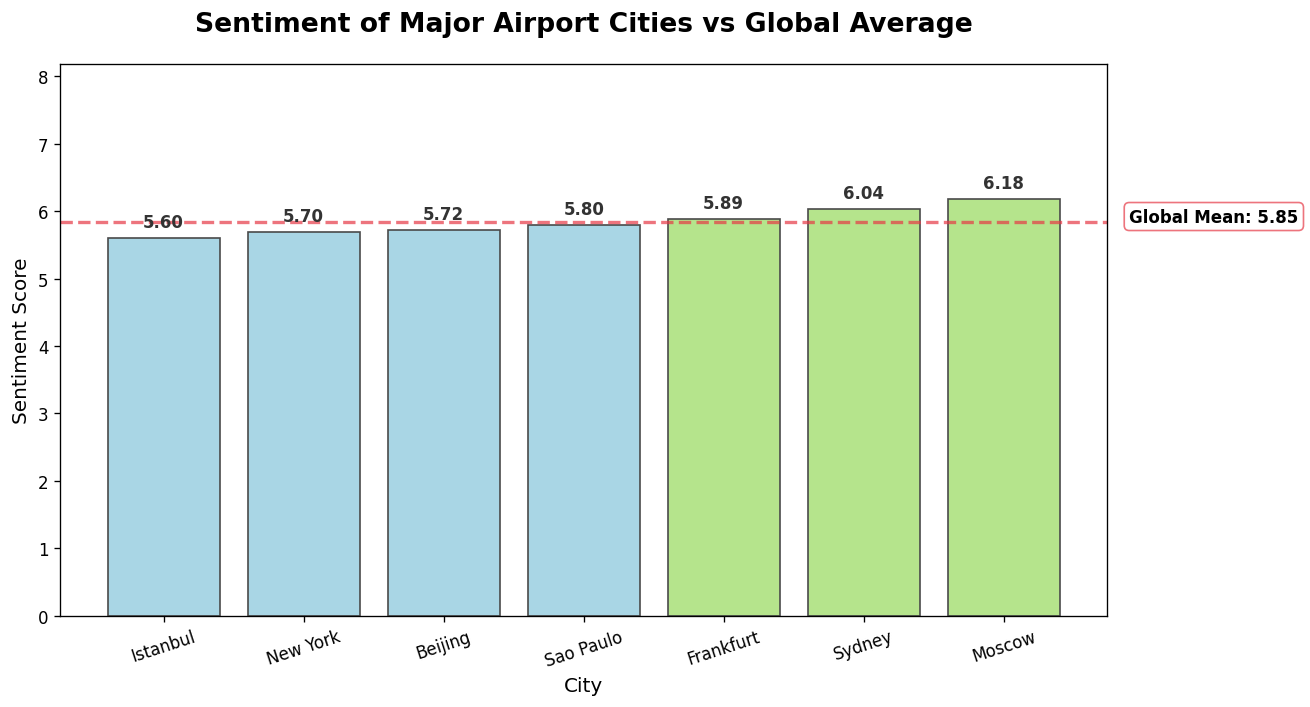

In [28]:
# Sort values for visual clarity
sent_df_sorted = sent_df.sort_values("sentiment_score")

# Softer pastel colors — below mean = pastel blue, above = pastel green
colors = ["#A9D6E5" if s < global_mean else "#B5E48C" 
          for s in sent_df_sorted["sentiment_score"]]

plt.figure(figsize=(11,6), dpi=120)
bars = plt.bar(sent_df_sorted["city"], sent_df_sorted["sentiment_score"],
               color=colors, edgecolor="#4A4A4A", linewidth=1)

# Add whitespace by extending y-axis limit
plt.ylim(0, sent_df_sorted["sentiment_score"].max() + 2)

# Label values above each bar
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             h + 0.1,                            # moved higher for whitespace
             f"{h:.2f}",
             ha='center', va='bottom',
             fontsize=10, fontweight='bold', color="#333333")

# Mean reference line
plt.axhline(global_mean, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)

# Mean label in a little box for visibility
plt.text(7.5, global_mean,
         f"Global Mean: {global_mean:.2f}",
         color='black', fontsize=10, fontweight='bold',
         ha='center',
         bbox=dict(facecolor='white', edgecolor='#E63946', boxstyle="round,pad=0.3", alpha=0.7))

# Titles & axis formatting
plt.title("Sentiment of Major Airport Cities vs Global Average",
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Sentiment Score", fontsize=12)
plt.xlabel("City", fontsize=12)
plt.xticks(rotation=18, fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


So it doesn't necessarily seem like the hub cities are better than average cities. 

# TF-IDF

So what's special about them? We investigate with TF-IDF. This time the Wikipedia articles are great, as they're longer and more descriptive than the review dataset.

In [29]:
import re
import pickle
import networkx as nx
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
from collections import Counter
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import pandas as pd
import math
import matplotlib.pyplot as plt

# Uncomment if first time using nltk
'''
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
'''

"\nnltk.download('punkt')\nnltk.download('punkt_tab')\nnltk.download('wordnet')\nnltk.download('omw-1.4')\nnltk.download('stopwords')\n"

Very extensive list of extra stop words:

In [30]:
extra_stop = {
    # Wikipedia/meta formatting
    "http","https","www","url","archive","web","page","site","retrieved","access",
    "reference","article","cite","ref","edit","revision","user","discussion","link",
    "publisher","status","title","id","html","com","wikipedia","wikimedia","commons",
    "website","jpeg","png","svg","jpg","php","htm","thumb","flagdeco",

    # generic leftover words
    "live","last","left","dead","may","june","july","august","september","february",
    "january","time","year","day","week","month","today","november","new","old","large",
    "small","major","great","many","several","work",

    # domains/country codes
    "org","gov","ru","uk","de","us","en","fr","nl","it","jp","br","sp","pt","cn","zh",
    "sec","nbsp","iad","au","nsw","tr","nyc",

    # generic geography words
    "city","town","capital","district","region","province","state","area","country",
    "world","place","located","situated","border","territory","coast","island","river",
    "valley","village","township","zone","metropolitan","suburb","downtown",

    # measurement/numbering
    "km","km2","square","population","million","thousand","percent","density",

    # travel/infrastructure
    "airport","international","station","terminal","railway","transport","service",
    "route","flight","airline",

    # language/grammar noise
    "one","two","three","first","second","third","use","used","also","often","however",
    "although","including","among","become","became","known","called","name","accessed",

    # specific location stopwords
    "moscow","york","beijing","bangkok","frankfurt","istanbul","sao","paulo","sydney",
    "russia","china","germany","turkey","brazil","thailand","united","states",
    "russian","american","german","australia","australian","brasil", "brazilian",
    "dictionaryofsydney","wale", "wales","stanbul",

    # generic nouns (city-neutral)
    "park","building","center","central","largest","national","museum","history",
    "government","environment","university","people","house","public","business",
    "department","census","record","journal","press","list","book","pdf","index","entry",

    # temporal leftovers
    "october","march","april","day","december",

    # formatting/misc junk
    "style","align","px","color","main","background","width","height","border","font",
    "size","family","bgcolor","ffffff","convert","file","lang","part","der","bahn",
    "sfn","centre","cent","road","line","high","low","nature","image","caption", 
    "ibge", "smh", "inmet", "qtu", "opn", "harvnb", "rk", "mo", "mkad"
}


In [31]:
# get rid of junk words (lemmatize)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

stop_words.update(extra_stop)

random.seed(42)  # for reproducibility

# we use the target countries we identified before. put it all in a dict.

txt_dict = dict()

for file in os.listdir("data/city_wikis"):
    if file.endswith(".txt") and file != "bangkok.txt":
        
        # read file text
        filepath = os.path.join("data/city_wikis", file)
        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read()
        txt_dict[file.replace(".txt","")] = text

# we combine and clean text per genre and make TF list
def clean_and_tokenize(text):
    text = text.lower()
    text = text.encode("utf-8", "ignore").decode("utf-8")
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(t)
        for t in tokens
        if len(t) > 1 and t not in stop_words
    ]
    return tokens

tf_lists = {}
for genre, texts in txt_dict.items():
    tokens = clean_and_tokenize(texts)
    counter = Counter(tokens)
    tf_lists[genre] = {w: c for w, c in counter.items() if c >= 2}

# results 
for genre, tf in tf_lists.items():
    print(f"\nTop 15 words for country: {genre.upper()}")
    for word, count in Counter(tf).most_common(15):
        print(f"{word:<15} {count}")


Top 15 words for country: MOSCOW
date            549
city            95
news            83
language        74
metro           72
ring            66
europe          55
soviet          55
th              52
century         43
moskva          38
system          38
building        34
kremlin         33
mo              33

Top 15 words for country: NEW_YORK
date            768
news            195
manhattan       176
time            105
city            105
brooklyn        98
book            93
queen           76
street          76
newspaper       72
isbn            68
home            67
nytimes         66
american        65
america         64

Top 15 words for country: BEIJING
date            538
news            139
chinese         117
city            87
day             87
precipitation   86
temple          84
science         73
mean            61
humidity        61
dynasty         59
language        56
sun             56
english         55
university      51

Top 15 words for country: SAO_

From this, we can create wordclouds!

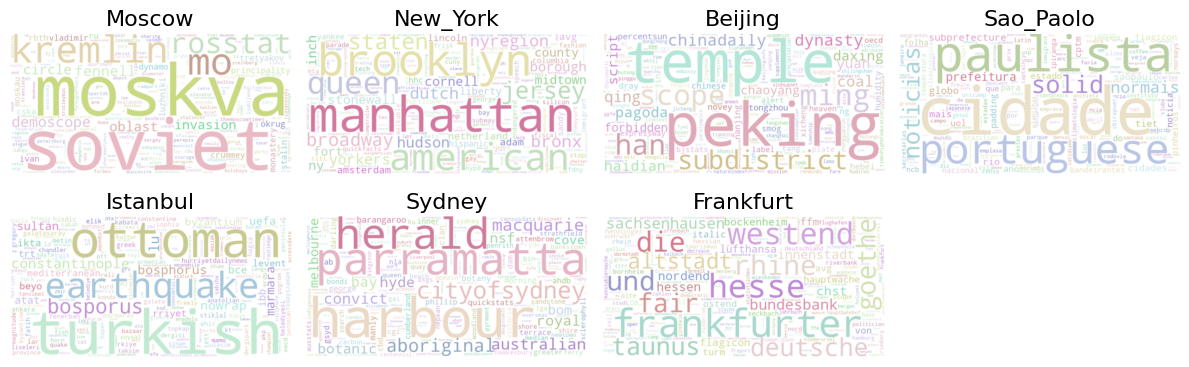

In [32]:
# get the idf values
N = len(tf_lists)

# count in how many genres each word appears
word_in_docs = Counter()
for genre, tf in tf_lists.items():
    for word in tf:
        word_in_docs[word] += 1

idf = {}
for word, doc_count in word_in_docs.items():
    # smooth IDF to avoid division by zero
    idf[word] = math.log(N / (1 + doc_count))  # using natural log (base e)

# get TF-IDF for each genre
tfidf_lists = {}
for genre, tf in tf_lists.items():
    tfidf = {word: tf[word] * idf[word] for word in tf}
    tfidf_lists[genre] = tfidf

# make some nice colors
def pastel_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    h = random.randint(0, 360)
    s = random.randint(30, 55) 
    l = random.randint(65, 85)
    return f"hsl({h}, {s}%, {l}%)"

# word clouds based on TF-IDF
n_genres = len(tfidf_lists)
cols = 4
rows = math.ceil(n_genres / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 2 * rows))
axes = axes.flatten()
for i, (genre, tfidf) in enumerate(tfidf_lists.items()):
    if not tfidf:
        continue
    max_val = max(tfidf.values())
    scaled_tfidf = {w: v / max_val for w, v in tfidf.items()}  # normalize 0–1

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        collocations=False,
        color_func=pastel_color_func
).generate_from_frequencies(scaled_tfidf)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"{genre.title()}", fontsize=16)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()